# Depth and Yaw Controllers

## Dynamic model based on BlueROV2 Heavy

<img src="bluerov.png" style="width:550px;height:270px" />

In [8]:
##Global
GRAVITY = 9.80665
FLUID_DENSITY = 1029    ## Fluid density of seawater

ROV_DIM_X = 0.457       ## Length
ROV_DIM_Y = 0.338       ## Width
ROV_DIM_Z = 0.254       ## Height

TETHER_DIAM = 0.008

ROV_AREA_X = ROV_DIM_Y * ROV_DIM_Z  ## Area of front (bow) and rear (stern) sides
ROV_AREA_Y = ROV_DIM_X * ROV_DIM_Z  ## Area of top and bottom
ROV_AREA_Z = ROV_DIM_X * ROV_DIM_Y  ## Area of left (port) and right (starboard) sides

VEHICLE_MASS = 11.5
VEHICLE_VOLUME = ROV_AREA_X*ROV_AREA_Y*ROV_AREA_Z

## Assume a uniform distribution of mass in the vehicle box
## Moment of Inertia solid cuboid of heigh h, width w, depth d and mass m
## Ih = M*(w^2 + d^2)/12
## Iw = M*(d^2 + h^2)/12
## Id = M*(w^2 + h^2)/12
MOMENT_OF_INERTIA_YAW = VEHICLE_MASS / 12.0 * (ROV_DIM_X * ROV_DIM_X + ROV_DIM_Y * ROV_DIM_Y)
MAX_Z_FORCE = 160.0
MAX_YAW_TORQUE = 30.208


## From BlueRobotics specs, all forces are in Newtons
BOLLARD_FORCE_XY = 137
BOLLARD_FORCE_Z = 88
T200_MAX_POS_FORCE = 40 #50
T200_MAX_NEG_FORCE = 40

## Estimate maximum yaw torque by looking at 4 thrusters (2 forward, 2 reverse), each mounted ~tangent to a circle with radius = 18cm
MAX_TORQUE_YAW = 0.18 * 2.0 * (T200_MAX_POS_FORCE + T200_MAX_NEG_FORCE)

DISPLACED_MASS = VEHICLE_VOLUME * FLUID_DENSITY
WEIGHT_IN_WATER = GRAVITY * (VEHICLE_MASS - DISPLACED_MASS)
HOVER_ACCEL_Z = WEIGHT_IN_WATER / VEHICLE_MASS ## Z acceleration required to hover

#=====================================================================================
# Drag constants, in the body frame (x forward, y left, z up)
#
# drag = 0.5 * density * area * velocity^2 * coefficient
#    the drag coefficient for a box is 1.0
#    the drag coefficient for an unfaired tether is 1.2
#
# The ROV constants below capture all but velocity:
#    constant = 0.5 * density * area * coefficient
#
# The tether constant below captures all but depth and velocity:
#    constant = 0.5 * density * width * coefficient
#=====================================================================================

DRAG_COEFFICIENT_X = 0.8    # Estimated
DRAG_COEFFICIENT_Y = 0.95   # Estimated
DRAG_COEFFICIENT_Z = 0.95   # Estimated

LINEAR_DRAG_X = 0.5 * FLUID_DENSITY * ROV_AREA_X * DRAG_COEFFICIENT_X
LINEAR_DRAG_Y = 0.5 * FLUID_DENSITY * ROV_AREA_Y * DRAG_COEFFICIENT_Y
LINEAR_DRAG_Z = 0.5 * FLUID_DENSITY * ROV_AREA_Z * DRAG_COEFFICIENT_Z

ANGULAR_DRAG_YAW = 0.5 * (LINEAR_DRAG_X + LINEAR_DRAG_Y)   ## Estimated

TETHER_DRAG_COEFFICIENT = 1.1   # Estimated
TETHER_DRAG = 0.5 * FLUID_DENSITY * TETHER_DIAM * TETHER_DRAG_COEFFICIENT
        

0.3096307916666667


In [9]:
class Controller:
    """PID controller."""

    def __init__(self, Kp, Ki, Kd, origin_time=None):
        if origin_time is None:
            origin_time = 0

        # Gains for each term
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.windup_guard = 20

        # Corrections (outputs)
        self.Cp = 0.0
        self.Ci = 0.0
        self.Cd = 0.0

        self.previous_time = origin_time
        self.sp_previous_time = origin_time
        self.previous_error = 0.0
        self.previous_setpoint = 0.0
        self.previous_altitud_error = 0.0
        self.previous_altitud = 0.0
        


    def setWindup(self, windup):
        self.windup_guard = windup
        
    def Update(self, error, current_time):
        """Update PID controller."""
        dt = current_time - self.previous_time
        if dt <= 0.0:
            return 0
        de = error - self.previous_error

        self.Cp = error
        self.Ci += error * dt
        self.Cd = de / dt
        
        ##Anti-windup
        if (self.Ci < -self.windup_guard):
            self.Ci = -self.windup_guard
        elif (self.Ci > self.windup_guard):
            self.Ci = self.windup_guard
        
        #Update previous values
        self.previous_time = current_time
        self.previous_error = error

        return (
            (self.Kp * self.Cp)    # proportional term
            + (self.Ki * self.Ci)  # integral term
            + (self.Kd * self.Cd)  # derivative term
        )
    
    def derivative_error(self, current_altitud_error, dt) :
        """ Computes the angular position error from altitude error """
        de = current_altitud_error - self.previous_altitud_error
        self.previous_altitud_error = de
        return (de/dt)
    
    def derivative_setpoint(self, current_sp, dt) :
        """ Computes the setpoint derivative """
        de = current_sp - self.previous_setpoint
        self.previous_setpoint = current_sp
        return (de/dt)
    
    ##forward terms are the inverse of the linear plant model
    #####
    ## Velocity => drag force / torque
    def drag_torque_yaw(self, velo_yaw):
        return velo_yaw * np.absolute(velo_yaw) * -ANGULAR_DRAG_YAW
    
    def drag_force_z(self, velo_z):
        return velo_z * np.absolute(velo_z) * -(TETHER_DRAG + LINEAR_DRAG_Z)
    
    def force_to_accel_z(self, force_z):
        return force_z / VEHICLE_MASS # TODO combine _xy and _z forms
    
    def torque_to_accel_yaw(self, torque_yaw):
        return torque_yaw / MOMENT_OF_INERTIA_YAW
    
    
    #ff_z = direction * self.force_to_accel_z(-self.drag_force_z(VELO_Z)) + self.HOVER_ACCEL_Z;
    def altitud_controller(self, error, current_time, VELO_Z):
        direction = -1
        bias = direction * self.force_to_accel_z(-self.drag_force_z(VELO_Z)) + HOVER_ACCEL_Z
        control_signal = self.Update(error, current_time)
        tau_linear = control_signal + bias
        if tau_linear > MAX_Z_FORCE:
            tau_linear = MAX_Z_FORCE
        if tau_linear < -MAX_Z_FORCE:
            tau_linear = -MAX_Z_FORCE
        #print(tau_linear)
        return tau_linear
    
    def yaw_controller(self, error, current_time, velo_yaw):
        direction = -1
        bias = direction * self.torque_to_accel_yaw(-self.drag_torque_yaw(velo_yaw))
        control_signal = self.Update(error, current_time)
        tau_linear = control_signal + bias
        if tau_linear > MAX_YAW_TORQUE:
            tau_linear = MAX_YAW_TORQUE
        if tau_linear < -MAX_YAW_TORQUE:
            tau_linear = -MAX_YAW_TORQUE
        #print(tau_linear)
        return tau_linear
    
   # velo_yaw * np.absolute(velo_yaw) * -ANGULAR_DRAG_YAW

In [10]:
class Bluerov:
    """Bluerov Class"""

    def __init__(self, position, velocity, acceleration, tau):
        self.x_ = position
        self.v_ = velocity
        self.acc = acceleration
        self.tau = tau
        
        self.T = np.array([[0.707,    0.707,   -0.707,  -0.707,    0,       0,       0,       0],  
                           [-0.707,   0.707,   -0.707,   0.707,    0,       0,       0,       0], 
                           [0,        0,        0,       0,       -1,       1,       1,      -1],
                           [0.06,    -0.06,     0.06,   -0.06,    -0.218,  -0.218,   0.218,   0.218],
                           [0.06,     0.06,    -0.06,   -0.06,     0.120,  -0.120,   0.120,  -0.120],
                           [-0.1888,  0.1888,   0.1888, -0.1888,   0,       0,       0,       0      ]])
        
        T_trans = self.T.transpose()
        temp = np.dot(self.T, T_trans)
        temp = np.linalg.inv(temp)
        self.T_plus = np.dot(T_trans, temp)
        
        K = np.array([40, 40, 40, 40, 40, 40, 40, 40])
        self.K_ = np.diag(K)
        self.K_inv = np.linalg.inv(self.K_)
    

    
    def motion_to_accel(self, force):
        
        force_z = force[2]
        torque_yaw = force[5]
        
        accel_z = force_z[0] / VEHICLE_MASS
        accel_yaw = torque_yaw[0] / MOMENT_OF_INERTIA_YAW
        
        return np.array([[0], [0], [accel_z], [0], [0], [accel_yaw]]) # Force vector
    
 
    
    def thruster_system(self, u):

        F = np.dot(self.K_, u)
        tau = np.dot(self.T, F)
        #print(tau)
        return tau
    
    
    def control_allocation(self, tau):

        temp = np.dot(self.T_plus, tau)    
        u = np.dot(self.K_inv, temp)

        return u
    
    
    def kinematics(self, v, p) :
        """ Given the current velocity and the previous position computes the p_dot """
        roll = p[3]
        pitch = p[4]
        yaw = p[5]

        rec = [np.cos(yaw)*np.cos(pitch), -np.sin(yaw)*np.cos(roll)+np.cos(yaw)*np.sin(pitch)*np.sin(roll), np.sin(yaw)*np.sin(roll)+np.cos(yaw)*np.cos(roll)*np.sin(pitch),
               np.sin(yaw)*np.cos(pitch), np.cos(yaw)*np.cos(roll)+np.sin(roll)*np.sin(pitch)*np.sin(yaw), -np.cos(yaw)*np.sin(roll)+np.sin(pitch)*np.sin(yaw)*np.cos(roll),
               -np.sin(pitch), np.cos(pitch)*np.sin(roll), np.cos(pitch)*np.cos(roll)]
        rec = np.array(rec).reshape(3,3)

        to = [1.0, np.sin(roll)*np.tan(pitch), np.cos(roll)*np.tan(pitch),
              0.0, np.cos(roll), -np.sin(roll),
              0.0, np.sin(roll)/np.cos(pitch), np.cos(roll)/np.cos(pitch)]
        to = np.array(to).reshape(3,3)

        p_dot = np.zeros(6)
        p_dot[0:3] = np.dot(rec, v[0:3])
        p_dot[3:6] = np.dot(to, v[3:6])
        return p_dot
    
        # Sensor simulation
    def position_sensing(self, p_real):
        pos_uncert_amplitude = 0.02 # 10m max error
        orient_uncert_amplitude = 0.5 # 5degr max error

        p_noisy = np.zeros_like(p_real)
        p_noisy[0:3] = p_real[0:3] + np.array([np.random.rand()*pos_uncert_amplitude,
                                         np.random.rand()*pos_uncert_amplitude,
                                         np.random.rand()*pos_uncert_amplitude])
        p_noisy[3:7] = p_real[3:7] + np.array([np.random.rand()*np.pi/180.0*orient_uncert_amplitude,
                                         np.random.rand()*np.pi/180.0*orient_uncert_amplitude,
                                         np.random.rand()*np.pi/180.0*orient_uncert_amplitude])
        return p_noisy

    def velocity_sensing(self, v_real):
        lin_vel_uncert_amplitude = 0.02 # 0.1 m/s max error
        ang_vel_uncert_amplitude = 0.5 # 1 deg/s max error

        v_noisy = np.zeros_like(v_real)
        v_noisy[0:3] = v_real[0:3] + np.array([np.random.rand()*lin_vel_uncert_amplitude,
                                         np.random.rand()*lin_vel_uncert_amplitude,
                                         np.random.rand()*lin_vel_uncert_amplitude])
        v_noisy[3:7] = v_real[3:7] + np.array([np.random.rand()*np.pi/180.0*ang_vel_uncert_amplitude,
                                         np.random.rand()*np.pi/180.0*ang_vel_uncert_amplitude,
                                         np.random.rand()*np.pi/180.0*ang_vel_uncert_amplitude])
        return v_noisy
    
    def integral(self, x_dot, x, t) :
        """ Computes the integral o x dt """
        x_ = (x_dot * t) + x
        #print(x_)
        return x_

      -29.49         0.87
      -29.50         0.87
      -29.49         0.87
      -29.49         0.87
      -29.51         0.87
      -29.51         0.87
      -29.51         0.87
      -29.51         0.87
      -29.50         0.87
      -29.50         0.87


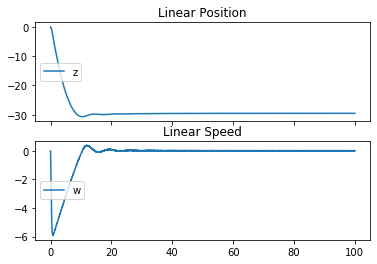

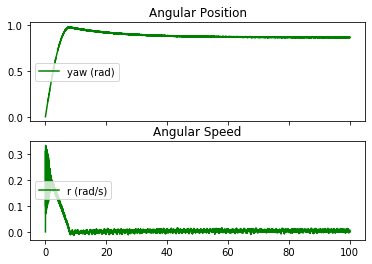

In [11]:
# The main loop of the simulation
num_actuators = 8
p = np.array(np.zeros(6))
v = np.array(np.zeros(6))
acc = np.array(np.zeros(6))
  
# Settings of the simulation time in seconds
period = 0.01
t_max = 100.0
prev_altitude = 0.0

##Altitud Setpoint
desired_altitud = -29.5
##YAW Setpoint
desired_yaw = 0.87;

time = np.arange(0.0,t_max,period)

# Initialise the position/velocity storage variable to the initial values
p_log = p
v_log = v

altitud_log = 0.0
w_velocity_log = 0.0

yaw_log = 0.0
r_velocity_log = 0.0

#Here you can change the resulting force for each degree of freedom
tau = np.array([[0], [0], [0], [0], [0], [0]]) # Force vector
bluerov = Bluerov(p, v, acc, tau) 


z_controller = Controller(10, 0.8, 5, 0)
yaw_controller = Controller(10, 0.6, 0.0, 0)
z_controller.setWindup(20)

for tstep in time[1:]:
    # Sensors
    p_sens = bluerov.position_sensing(p)
    v_sens = bluerov.position_sensing(v)
    
    altitude = p_sens[2]
    yaw = p_sens[5]
    w_velocity = v_sens[2]
    r_velocity = v_sens[5]
       
    #if tstep > 50:
    #    desired_altitud = -1
    
    ##Controller
    altitude_error = desired_altitud - altitude
    yaw_error = desired_yaw - yaw
    #w_error = z_controller.derivative_error(altitude_error, period)
    
    linear_z_tau = z_controller.altitud_controller(altitude_error, tstep, w_velocity)
    linear_yaw_tau = yaw_controller.yaw_controller(yaw_error, tstep, r_velocity)
    linear_tau = np.array([[0], [0], [linear_z_tau], [0], [0], [linear_yaw_tau]]) # Force vector
    ##
    
    ##This function return the thruster's control input 
    u = bluerov.control_allocation(linear_tau)
  
    ##Force/Torque input
    tau = bluerov.thruster_system(u)

    #v_dot = bluerov.force_to_accel_z(tau) 
    v_dot = bluerov.motion_to_accel(tau)
    acc = v_dot


    v_dot = np.squeeze(np.asarray(v_dot))
    v = bluerov.integral(v_dot, v, period)

    p_dot = bluerov.kinematics(v,p)
    p = bluerov.integral(p_dot, p, period)
    
    ## Print the last 10 values
    if tstep >= (t_max - period*10):
        print("% 12.2f % 12.2f" % (altitude, yaw))
    


    # Saving the simulated values for later plotting
    altitud_log = np.vstack((altitud_log, altitude))
    w_velocity_log = np.vstack((w_velocity_log, w_velocity))
    
    yaw_log = np.vstack((yaw_log, yaw))
    r_velocity_log = np.vstack((r_velocity_log, r_velocity))
    
    
# The plotting
fig, axs = plt.subplots(2,1, sharex='col')
axs[0].plot(time, altitud_log)
axs[0].set_title('Linear Position')
axs[0].legend(['z',], loc="center left")

axs[1].plot(time, w_velocity_log)
axs[1].set_title('Linear Speed')
axs[1].legend(['w'], loc="center left")
plt.show()

fig, axs = plt.subplots(2,1, sharex='col')
axs[0].plot(time, yaw_log, color='green')
axs[0].set_title('Angular Position')
axs[0].legend(['yaw (rad)',], loc="center left")

axs[1].plot(time, r_velocity_log, color='green')
axs[1].set_title('Angular Speed')
axs[1].legend(['r (rad/s)'], loc="center left")
plt.show()